## Notebook for inferrering inference in a TAP brain

In [33]:
%pylab inline
import sys, importlib
sys.path.append('../code')
from notebookutils import *
# Also import modules using aliases so I can reload them when I make an edit
import notebookutils as ntutils
import tapdynamics as tap
import particlefilter as pfil
importlib.reload(ntutils)
importlib.reload(tap)
importlib.reload(pfil)

Populating the interactive namespace from numpy and matplotlib


<module 'particlefilter' from '/Users/cartergoldman/sussex/variational_vs_sampling/inferring_inference/coarse_graining_scripts/notebooks/../code/particlefilter.py'>

## 1. Initialize parameters to true values

In [12]:
# set noise seed
noise_seed = 2022
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))


# Ns = no. of latent variables, Ny = no. of inputs
Ns, Nr, Ny = 2,2,2

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # message passing parameters of the TAP equation

# Connectivity matrix between state nodes
# Ns x Ns
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0, 3, 'nonferr' # interaction matrix settings
J = array([[0,.2],[.2,0]])

# Connectivity matrix between state and observation nodes
# Ns x Ny
V = array([[.3,.3],[.3,3]])
# Empty embedding matrix because we don't care about neural response

embedding_arr = (Nr,Ns)
U = np.zeros(embedding_arr)
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

noise_seed = 2022


## 2. Run algorithm to get latent probabilities

In [13]:
B_train, B_val = 2000, 500       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 1000                         # No. of time steps 
kernel  = 30                     # Sliding window
stride = 5                       # how big each jump is
                                 # Here we have consistent input for the entire time period

##################
# These parameters are not used since observations are binary                                 
T_low, T_high = T, T+1           # range of time periods for which input is held constant
yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations
##################
# Specify sampling or message passing function
# runTAP - message passing
# runTAPSampling - sampling
TAP_func=runTAP
y_train, x_train, r_train = tap.generate_TAPdynamics(theta, params, B_train, T, T_low, T_high, yG_low, yG_high,kernel,stride,TAP_func=TAP_func)

y_val, x_val, r_val = tap.generate_TAPdynamics(theta, params, B_val, T, T_low, T_high, yG_low, yG_high,kernel,stride,TAP_func=TAP_func)

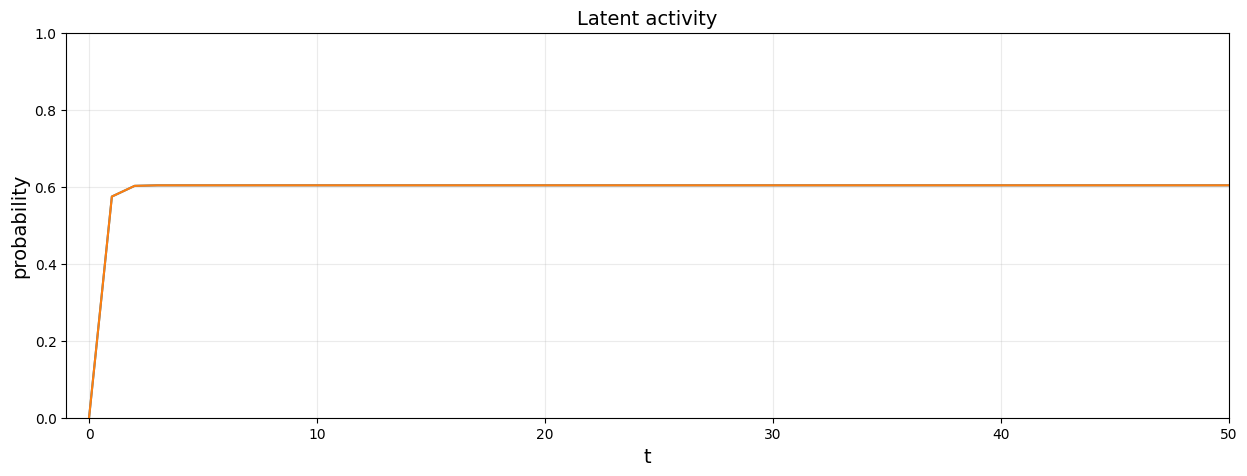

In [14]:
# if you get an error that np is not defined run first cell in TrainTAPbrain.ipynb to load necessary dependencies
fig, axs = plt.subplots(1,1, figsize=(15, 5))

axs.plot(x_train[0].T)

axs.axis([-1, 50, 0, 1])


axs.grid(True, alpha=0.25)
axs.set_xlabel('t', fontsize=14)

axs.set_ylabel('probability', fontsize=14)
axs.set_title('Latent activity', fontsize=14)


plt.show()

### 2.2. Initialize the rest of the parameters

In [15]:
G_init    = 0.01*np.random.randn(18)
G_init[0], G_init[8], G_init[9], G_init[17] = 0, 0, 0, 0
U_init = U

J_init    = 0.1*Create_J(Ns, 0, params['Jtype'], params['self_coupling_on'])  # create a fully connected initial J with small initial values

if Ns <= Ny:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

### 3. Generate measurements for the particle EM algorithm

In [18]:
# Convert data to torch tensors

device, dtype = "cpu", torch.float64

B = B_train

# Q_process_ = torch.tensor(Q_process,device=device,dtype=dtype)
# Q_obs_     = torch.tensor(Q_obs,device=device,dtype=dtype)

# P_process_ = Q_process_.inverse()
# P_obs_     = Q_obs_.inverse()

# r_brain_   = torch.tensor(r_brain,device=device,dtype=dtype)
y_         = torch.tensor(y_train,device=device,dtype=dtype)
latents_   = torch.tensor(x_train,device=device,dtype=dtype)

G_      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J_      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U_      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V_      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat_  = torch.tensor(G_init,device=device,dtype=dtype,requires_grad=True)
U_hat_  = torch.tensor(U_init,device=device,dtype=dtype,requires_grad=True)
V_hat_  = torch.tensor(V_init,device=device,dtype=dtype,requires_grad=True)
J_hat_vec_ = torch.tensor(JMatToVec(J_init),device=device,dtype=dtype,requires_grad=True)
J_hat_ = JVecToMat_torch(J_hat_vec_,Ns)
# b_hat_ = torch.tensor(b_init,device=device,dtype=dtype,requires_grad=True) if model_type else 0

## 4. Run particle EM

In [34]:
lrate = 2e-3
NIterations = 25000


opt_params = [G_hat_, J_hat_vec_, V_hat_]

optimizer = torch.optim.Adam(opt_params, lr=lrate, betas=(0.9, 0.999))

batch_size = 4

LLVec = []  # record the log likelihoods

t_st = time.time()

for iteration in range(NIterations):
    
    if iteration == NIterations//2:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/2, betas=(0.9, 0.999))

    if iteration == 3*NIterations//4:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/4, betas=(0.9, 0.999))
        
    #zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # select indices of batches
    idx = np.random.randint(low=0,high=B,size=batch_size)
    
    # run particle filter to get posterior for E-step
    # with torch.no_grad():
    #     LL_b_, x_b_, P_b_, W_b_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[idx]-b_hat_, y_[idx], P_process_, P_obs_, Np)

        
    # E-step to compute Q(theta,theta_n)
    C_ = pfil.QfunctionSimple(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), y_[idx,:,:], latents_[idx,:,:])
    
    # M-step
    C_.backward() 
    G_hat_.grad[0], G_hat_.grad[9]  = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()
    1
    # Compute and record log likelihood on the test data
    if (iteration+1)%100 == 0:
        with torch.no_grad():
            LL_rec_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[B:B+10]-b_hat_, y_[B:B+10], P_process_, P_obs_, Np)[0]
            LLVec.append(LL_rec_.mean())
    
    if (iteration+1)%1000 == 0:
        # print(f"[{iteration+1}] time elapsed = {(time.time() - t_st)/60:.1f} mins , log likelihood = {LL_rec_.mean():.1f} ")
        print('[%d] time elapsed = %.1f, log likelihood: %.1f' %(iteration + 1, (time.time() - t_st)/60, LL_rec_.mean()))
        
print("Finished training.")

NameError: name 'r_brain_' is not defined

## 5. Save required variables

In [ ]:
G_hat = G_hat_.detach().cpu().data.numpy()
J_hat = J_hat_.detach().cpu().data.numpy()
U_hat = U_hat_.detach().cpu().data.numpy()
V_hat = V_hat_.detach().cpu().data.numpy()
b_hat = b_hat_.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat  = EstimatePermutation_ICA(U, U_hat)
PermMat_ = torch.tensor(PermMat,device=device,dtype=dtype,requires_grad=False)
PermMat_init_ = torch.tensor(PermMat_init,device=device,dtype=dtype,requires_grad=False)


# Permute the order of all the inferred variables to match ground truth order and convert to numpy arrays
x_init = torch.matmul(PermMat_init_.t(), x_init_).data.numpy()
x_hat  = torch.matmul(PermMat_.t(), x_hat_).data.numpy() 

r_init = r_init_.data.numpy()
r_hat  = r_hat_.data.numpy()

J_hat  = permuteJ(J_hat, PermMat)
J_init = permuteJ(J_init, PermMat_init)

U_hat  = np.dot(U_hat, PermMat)
U_init = np.dot(U_init, PermMat_init)

V_hat  = np.dot(PermMat.T, V_hat)
V_init = np.dot(PermMat_init.T, V_init)

In [ ]:
params['Q_obs'] = Q_obs

# initial values of parameters
init_parameters = {'G_init':G_init, 'J_init':J_init, 'U_init':U_init, 'V_init':V_init, 'b_init':b_init}

# inferred parameters
inferred_parameters = {'G_hat':G_hat, 'J_hat':J_hat, 'U_hat':U_hat, 'V_hat':V_hat, 'b_hat':b_hat }

if TAP_func == runSamplingTAP:
    TAP_func_str = 'sampling_'
else:
    TAP_func_str = ''

fname = './results/inference_' + TAP_func_str + brain_name  + '_snr_' + str(int(np.round(SNR))) + '.pkl'
print(fname)

with open(fname, 'wb') as f:  
    pickle.dump([theta, params, init_parameters, inferred_parameters], f)
f.close()

## 6. Visualizing results

In [ ]:
def reshapeG(GVec):
    GVec = GVec.tolist()
    GVec.pop(9)
    GVec.pop(0)
    return np.array(GVec)

def offdiagonal(J):
    J_temp = J.copy()
    M = J.shape[0]
    for i in range(M):
        J_temp[i,i] = np.nan
    return J_temp

In [ ]:
alpha = 0.5

fig, axs = subplots(3,3,figsize=(20,20))

axs[0,0].imshow(J,cmap='RdBu')
axs[0,0].set_title('J matrix')

axs[0,1].plot([0,len(LLVec)],LL_tp_.mean().item()*np.ones([2]),'g-')
axs[0,1].plot(LLVec,'b')
axs[0,1].set_xlabel('iterations',fontsize=14)
axs[0,1].set_ylabel('log likelihood', fontsize=14)
#axs[0,1].axis([0,200,-6000,-3000])

axs[0,2].plot(r_brain[B:B+10,:,T_st:].flatten(),r_init[0:10,:,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
axs[0,2].plot(r_brain[B:B+10,:,T_st:].flatten(),r_hat[0:10,:,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
axs[0,2].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
axs[0,2].set_xlabel(r'$r_{\mathrm{true}}$',fontsize=16)
axs[0,2].set_ylabel(r'$\hat{r}$',fontsize=16)
axs[0,2].legend(['init', 'post EM'], fontsize=14)
axs[0,2].axis('square')
axs[0,2].axis([rmin,rmax,rmin,rmax])
axs[0,2].grid(True)

axs[1,0].plot(x[B:,:,T_st:].flatten(), x_init[...,T_st:].flatten(),'r.', ms=1, alpha=alpha)
axs[1,0].plot(x[B:,:,T_st:].flatten(), x_hat[...,T_st:].flatten(),'b.', ms=1, alpha=alpha)
axs[1,0].plot([0,1],[0,1], linewidth=0.5)
axs[1,0].set_xlabel(r'$x_{\mathrm{true}}$', fontsize=16)
axs[1,0].set_ylabel(r'$\hat{x}$', fontsize=16)
axs[1,0].legend(['init', 'post EM'], fontsize=14)
axs[1,0].axis('square')
axs[1,0].axis([0,1,0,1])

axs[1,1].plot(U.flatten(),U_init.flatten(),'r.',markersize=3)
axs[1,1].plot(U.flatten(),U_hat.flatten(),'b.',markersize=3)
axs[1,1].axis('square')
axs[1,1].plot([-4,4],[-4,4],linewidth=0.5)
axs[1,1].axis([-4,4,-4,4])
axs[1,1].set_xlabel(r'$U_{\mathrm{true}}$',fontsize=16)
axs[1,1].set_ylabel(r'$\hat{U}$',fontsize=16)
axs[1,1].legend(['init', 'post EM'],fontsize=14)
axs[1,1].grid(True)

axs[1,2].plot(V.flatten(),V_init.flatten(),'r.',markersize=3)
axs[1,2].plot(V.flatten(),V_hat.flatten(),'b.',markersize=3)
axs[1,2].axis('square')
axs[1,2].plot([-1,1],[-1,1],linewidth=0.5)
axs[1,2].axis([-1,1,-1,1])
axs[1,2].set_xlabel(r'$V_{\mathrm{true}}$',fontsize=16)
axs[1,2].set_ylabel(r'$\hat{V}$',fontsize=16)
axs[1,2].legend(['init', 'post EM'],fontsize=14)
axs[1,2].grid(True)

axs[2,0].plot(reshapeG(G),'.',color='green', ms=10)
axs[2,0].plot(reshapeG(G_init),'r.', ms=10)
axs[2,0].plot(reshapeG(G_hat),'b.', ms=10)
axs[2,0].grid(True)
axs[2,0].set_xlabel('index',fontsize=14)
axs[2,0].set_ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
axs[2,0].legend(['true','init','inferred'],fontsize=14)
axs[2,0].axis([-0.5,15.5,-8.5,8.5])
axs[2,0].set_xticks(np.arange(16))

axs[2,1].plot(JMatToVec(offdiagonal(J)),JMatToVec(offdiagonal(J_init)),'r.',markersize=8)
axs[2,1].plot(JMatToVec(offdiagonal(J)),JMatToVec(offdiagonal(J_hat)),'b.',markersize=8)
axs[2,1].axis('square')
axs[2,1].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
axs[2,1].set_ylabel(r'$\hat{J}$',fontsize=16)
axs[2,1].legend(['init', 'post EM'],fontsize=14)
axs[2,1].grid(True)
# axs[2,1].axis([-1.5,1.5,-1.5,1.5])
axs[2,1].axis([-2,2,-2,2])
axs[2,1].set_title('off diagonal elements of J')

axs[2,2].plot(np.diag(J), np.diag(J_init), 'r.', markersize=8)
axs[2,2].plot(np.diag(J), np.diag(J_hat), 'b.',markersize=8)
axs[2,2].axis('square')
axs[2,2].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
axs[2,2].set_ylabel(r'$\hat{J}$',fontsize=16)
axs[2,2].legend(['init', 'post EM'],fontsize=14)
axs[2,2].grid(True)
# axs[2,2].axis([-1.5,1.5,-1.5,1.5])
axs[2,2].axis([-2,2,-2,2])
axs[2,2].set_title('self couplings')

show()

## 7. Validate on new test data

In [ ]:
B_val = 100
T_clip = 10
y_val = generate_Input(params, B_val, T+T_clip, T_low, T_high, yG_low, yG_high)

x0 = np.random.rand(Ns,B_val) # initial values

# Run TAP dynamics using true theta
x_val 	= runTAP(x0, y_val, Q_process, Q_obs, theta, params['nltype'])

# Run TAP dynamics using inferred theta
theta_hat = np.concatenate([np.array([lam]), G_hat, JMatToVec(J_hat), U_hat.flatten('F'), V_hat.flatten('F') ])
x_hat_val = runTAP(x0, y_val, Q_process, Q_obs, theta_hat, params['nltype'])

x_val = x_val[...,T_clip:].transpose(1,2,0)
x_hat_val = x_hat_val[...,T_clip:].transpose(1,2,0)
truth = x_val.flatten()
test = x_hat_val.flatten()

In [ ]:
# print(f"RMSE = {np.sqrt(np.mean((truth - test)**2)):.3f}")
print('RMSE = %.3f' %(np.sqrt(np.mean((truth - test)**2))))

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].plot(truth,test,'r.',markersize=1,alpha=0.1)
axs[0].plot([0,1],[0,1],linewidth=0.5)
axs[0].set(xlabel='with true parameters', ylabel='with inferred parameters', title='TAP dynamics with true vs inferred parameters')
axs[0].axis('square')
axs[0].axis([0,1,0,1])

axs[1].hist(test-truth,50)
axs[1].set_xlabel(r'$\hat{x} - x$',fontsize=16)
axs[1].set_ylabel('count', fontsize=14)
axs[1].set_title('Histogram of test error', fontsize=14)
axs[1].grid(True)
plt.show()